# STEP 0

## 0.1. Imports


In [1]:
import pickle
import numpy                    as np
import pandas                   as pd
import seaborn                  as sns
import sweetviz                 as sv
import seaborn                  as sns
import xgboost                  as xgb
import lightgbm                 as lgb
import matplotlib.pyplot        as plt
from sklearn                    import metrics
from sklearn.svm                import SVC 
from sklearn.compose            import ColumnTransformer
from sklearn.pipeline           import Pipeline
from sklearn.linear_model       import LogisticRegression
from sklearn.preprocessing      import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.preprocessing      import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection    import GridSearchCV
from sklearn.model_selection    import train_test_split
from sklearn.model_selection    import StratifiedKFold, KFold


c:\Users\Usuário\repos\google_ml\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0.2. Helper Functions

In [2]:
# ===================================================================
# Configura os gráficos
def jupyter_settings():
    %matplotlib inline
    # %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [22, 9]
    plt.rcParams['font.size'] = 21

    # display(HTML('<style>.conteiner{width:100% !important;}</style>'))

    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    # configura o pandas para quantidade de casas decimais
    pd.set_option('display.float_format', lambda x: '%.2f' % x)

    sns.set()

jupyter_settings()



# Calcula e retorna um dataframe com as métricas sem validação cruzada
def simple_metrics(model_name, test, predict):
    data = [
        [
            model_name,
            metrics.precision_score(test, predict),
            metrics.recall_score(test, predict),
            metrics.f1_score(test, predict),
            metrics.roc_auc_score(test, predict),
        ]
    ]
    columns = ["Model", "Precision", "Recall", "F1", "AUC"]
    metrics_table = pd.DataFrame(data, columns=columns)
    return metrics_table


def tuning_hyperparams(pre_processor, modelo, model_name, param, X, y):
    '''
        Método que utiliza o Pipeline para pré processar os dados e calcula quais são 
        os melhores hiperparâmetros baseado no modelo e no dicionário de hiperparâmetros 
        informados. Retorna um dicionário com os parâmetros testados e os melhores valores
        de cada um.

        pre_processor: objeto da classe ColumnTransformer escolhido para os dados
        modelo: instância do algoritimo a ser usado
        model_name: String com o apelido do modelo a ser usado
        param: Dict - dicionário com os hiperparams e os valores a serem testados
        X: dados de treino
        y: variável target dos dados de treino

        return dict
    '''
    # criando o modelo usando pipeline
    model = Pipeline(
        steps=[
            ("preprocessor", pre_processor),
            (model_name, modelo),
        ]
    )

    # Criando o dicionario de hiperparâmetros
    test_keys = [model_name + '__' + x for x in param.keys()] # colocar duplo underscore entre o nome do modelo e o nome do parâmetro  (lr__)
    test_values = list(param.values())
    parameters = { test_keys[i]: test_values[i] for i in range(len(test_keys)) }

    # Rodando 5-fold cross-validation com gridsearch
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    grid = GridSearchCV(
        model, param_grid=parameters, cv=kfold, n_jobs=-1, return_train_score=True
    )

    grid.fit(X=X, y=y)

    # Imprime os melhores parâmetros
    param = grid.best_params_
    return param

## 0.3. Loading Data

In [3]:
test_raw = pd.read_csv('../data/test.csv')
train_raw = pd.read_csv('../data/train.csv')

# 1 - Data understanding


In [4]:
df = train_raw.copy()
df.head(3)

,id_do_caso,continente,educacao_do_empregado,tem_experiencia_de_trabalho,requer_treinamento_de_trabalho,num_de_empregados,ano_de_estabelecimento,regiao_de_emprego,salario_prevalecente,unidade_de_salario,posicao_em_tempo_integral,status_do_caso
0,EZYV10567,Europa,Ensino Médio,N,S,2087,1855,Sul,69711.24,Ano,S,Negado
1,EZYV5505,Ásia,Mestrado,S,N,5991,2003,Meio-Oeste,52931.38,Ano,S,Aprovado
2,EZYV5207,Ásia,Ensino Médio,N,N,1426,2000,Ilha,110830.21,Ano,S,Negado


## 1.1. Rename Columns

In [5]:
df.columns = ['id', 'continente', 'escolaridade',
       'tem_experiencia', 'requer_treinamento',
       'num_empregados', 'ano_fundacao', 'regiao',
       'salario_medio', 'periodicidade',
       'tempo_integral', 'status']

## 1.2. Data Dimensions

In [6]:
# Conferindo a volumetria
print(f"Quantidade de linhas:   {df.shape[0]}")
print(f"Quantidade de colunas:  {df.shape[1]}")
print(f"IDs únicos:             {df.id.nunique()}\n")

Quantidade de linhas:   17836
Quantidade de colunas:  12
IDs únicos:             17836



## 1.3. Data Types

In [7]:
df.dtypes

id                     object
continente             object
escolaridade           object
tem_experiencia        object
requer_treinamento     object
num_empregados          int64
ano_fundacao            int64
regiao                 object
salario_medio         float64
periodicidade          object
tempo_integral         object
status                 object
dtype: object

## 1.4. Change Data Types

In [8]:
'''
Alterando os tipos de int64 e float64 para int32 e float32 respectivamente com o 
intuito de melhorar a performance além de alterar as variáveis nominais para o tipo 
category que consome menos memória que o tipo object.
'''
df.id = df.id.astype('string')
df.continente = df.continente.astype('category')
df.escolaridade = df.escolaridade.astype('category')
df.tem_experiencia = df.tem_experiencia.astype('category')
df.requer_treinamento = df.requer_treinamento.astype('category')
df.num_empregados = df.num_empregados.astype('int32')
df.ano_fundacao = df.ano_fundacao.astype('int32')
df.regiao = df.regiao.astype('category')
df.salario_medio = df.salario_medio.astype('float32')
df.periodicidade = df.periodicidade.astype('category')
df.tempo_integral = df.tempo_integral.astype('category')
df.status = df.status.apply(lambda status: 0 if status == 'Negado' else 1)
df.status = df.status.astype('int32')

## 1.5. Check NA


In [9]:
df.isnull().mean()

id                   0.00
continente           0.00
escolaridade         0.00
tem_experiencia      0.00
requer_treinamento   0.00
num_empregados       0.00
ano_fundacao         0.00
regiao               0.00
salario_medio        0.00
periodicidade        0.00
tempo_integral       0.00
status               0.00
dtype: float64

## 1.6. Descriptive Statistical


In [10]:
# Separando os atributos entre numéricos e categóricos
numerical_attributes = df.select_dtypes(include=['int32', 'float32'])
categorical_attributes = df.select_dtypes(exclude=['int32', 'float32'])

### 1.6.1 Numerical Features

In [11]:
numerical_attributes.describe().T

,count,mean,std,min,25%,50%,75%,max
num_empregados,17836.00,5726.50,23321.38,-26.00,1023.00,2117.00,3504.25,602069.00
ano_fundacao,17836.00,1979.49,42.10,1800.00,1976.00,1997.00,2005.00,2016.00
salario_medio,17836.00,74327.42,52795.86,2.14,33892.91,70106.92,107564.71,319210.28
status,17836.00,0.67,0.47,0.00,0.00,1.00,1.00,1.00


### 1.6.2 Categorical Features

In [12]:
display( pd.DataFrame( categorical_attributes.apply(lambda x: x.unique().shape[0]), columns=[ 'Valores únicos'], ).sort_values('Valores únicos'))

,Valores únicos
tem_experiencia,2
requer_treinamento,2
tempo_integral,2
escolaridade,4
periodicidade,4
regiao,5
continente,6
id,17836


### 1.7 Target Feature

In [13]:
df.status.value_counts()

1    11937
0     5899
Name: status, dtype: int64

# 2 - Exploratory data analisys

In [14]:
# my_report = sv.analyze(df, target_feat ='status')
# my_report.show_html()

## 2.1. Análise Univariada

[Text(0.5, 1.0, 'Salário médio da profissão')]

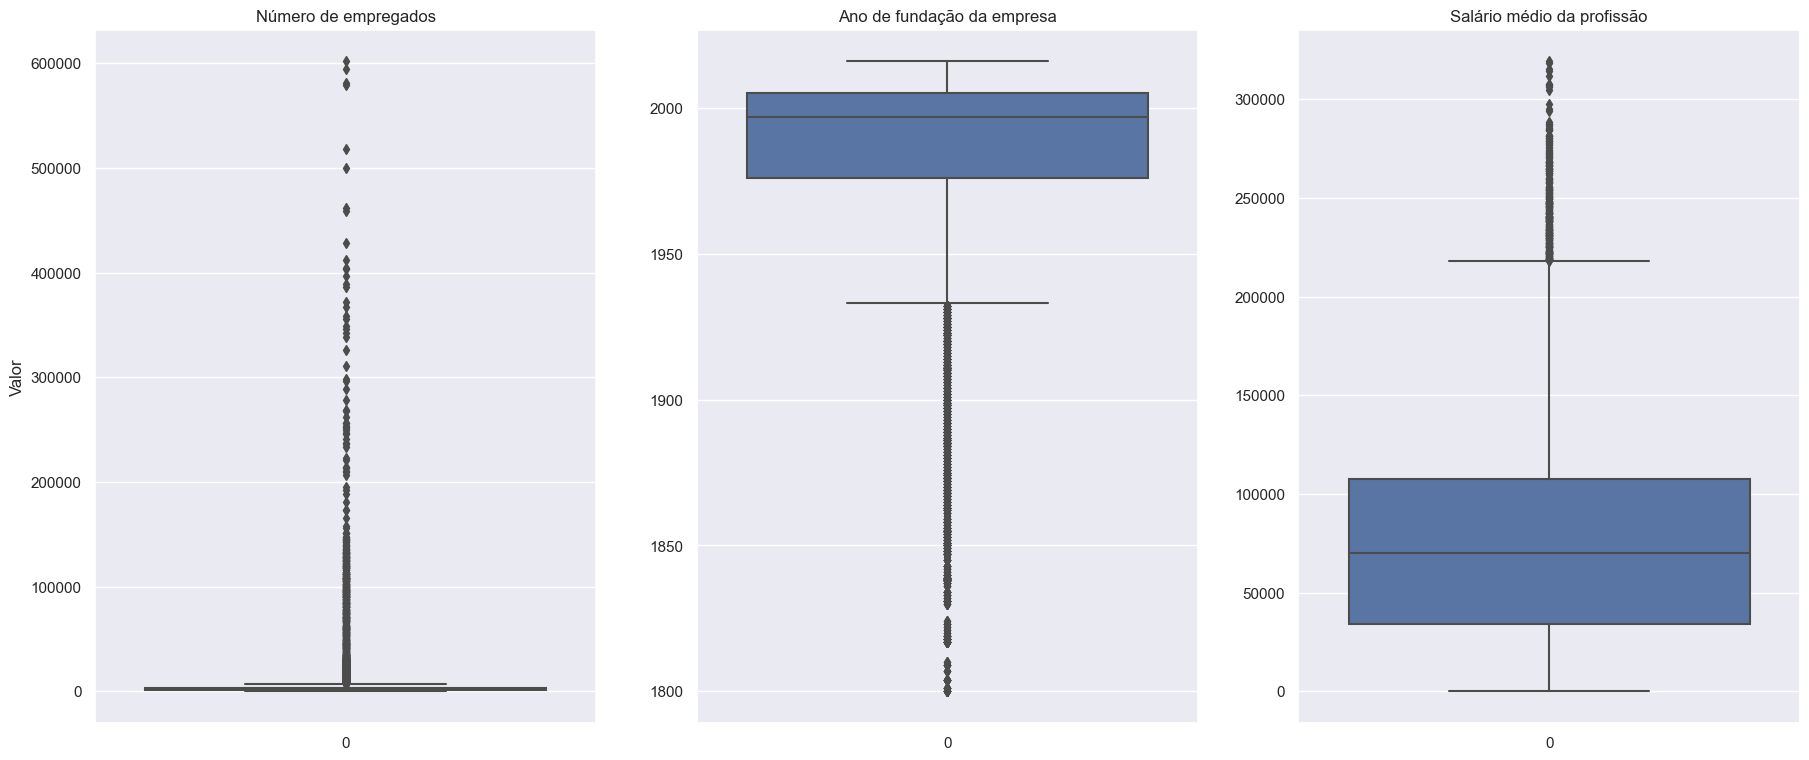

In [15]:
plt.subplot(1,3,1)
sns.boxplot(numerical_attributes['num_empregados']).set(title='Número de empregados', ylabel="Valor")

plt.subplot(1,3,2)
sns.boxplot(numerical_attributes['ano_fundacao']).set(title='Ano de fundação da empresa',)

plt.subplot(1,3,3)
sns.boxplot(numerical_attributes['salario_medio']).set(title='Salário médio da profissão')

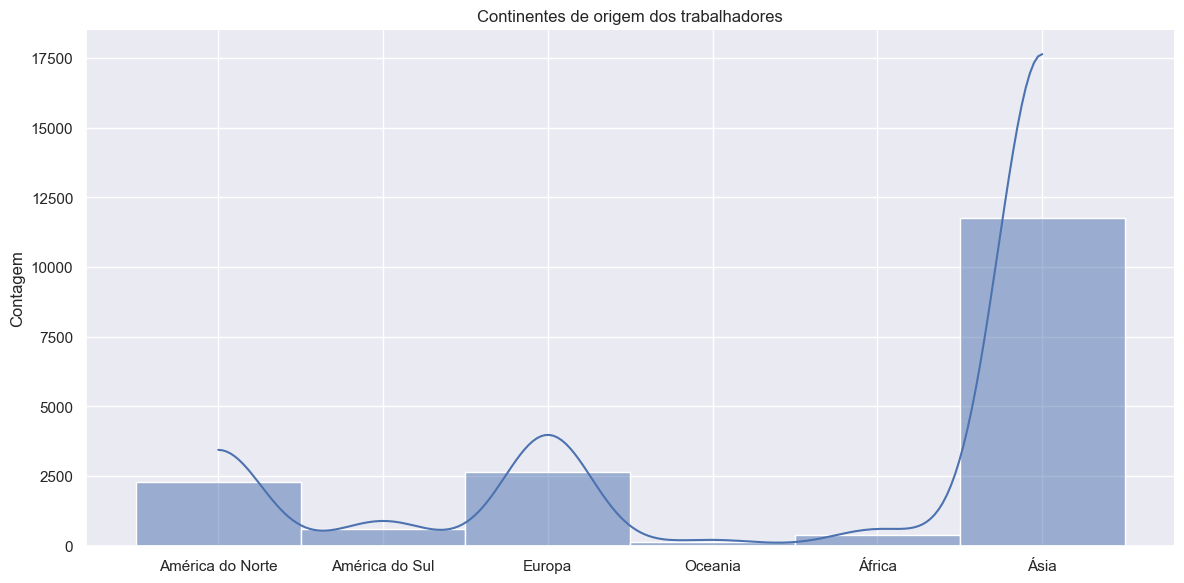

In [16]:
sns.displot(data=df, x="continente", kde=True, height=6, aspect=2).set(title='Continentes de origem dos trabalhadores', xlabel=None, ylabel='Contagem');

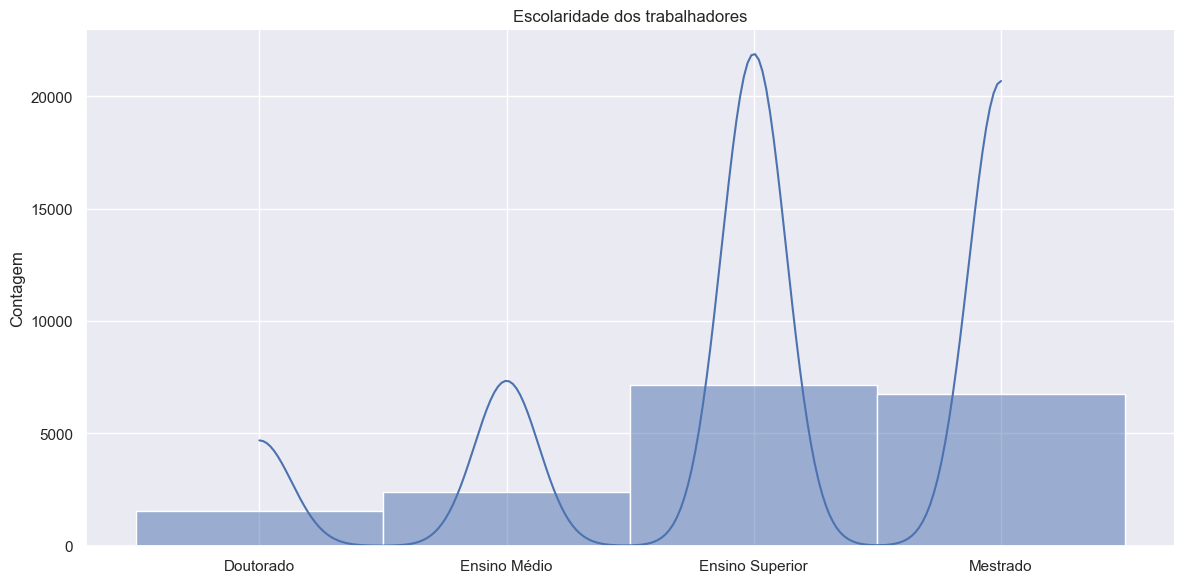

In [17]:
sns.displot(data=df, x="escolaridade", kde=True, height=6, aspect=2).set(title='Escolaridade dos trabalhadores', xlabel=None, ylabel='Contagem');

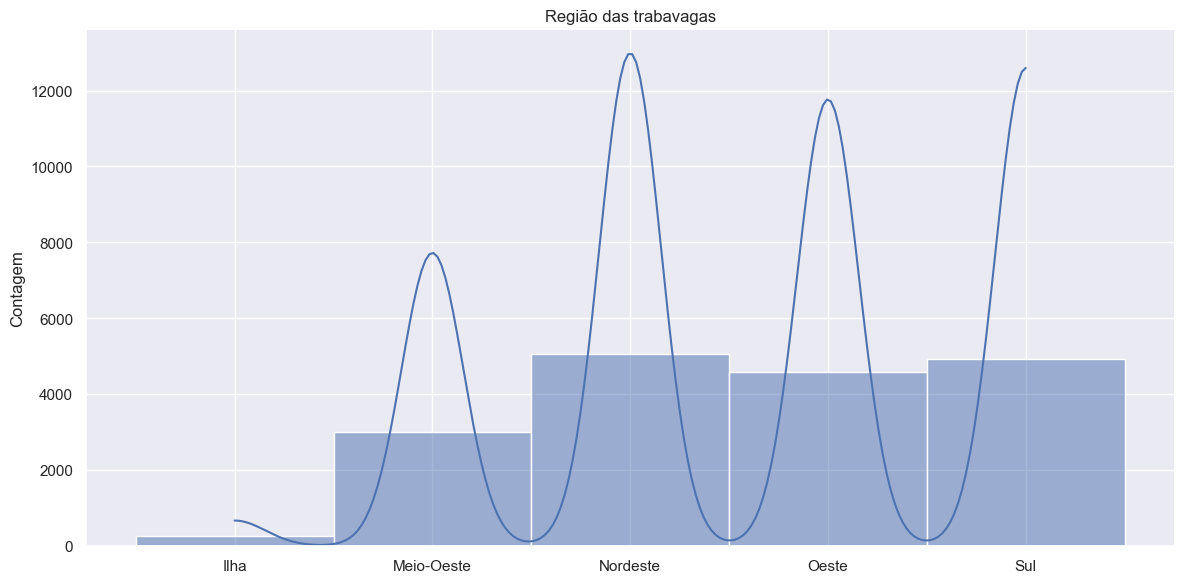

In [18]:
sns.displot(data=df, x="regiao", kde=True, height=6, aspect=2).set(title='Região das trabavagas', xlabel=None, ylabel='Contagem');

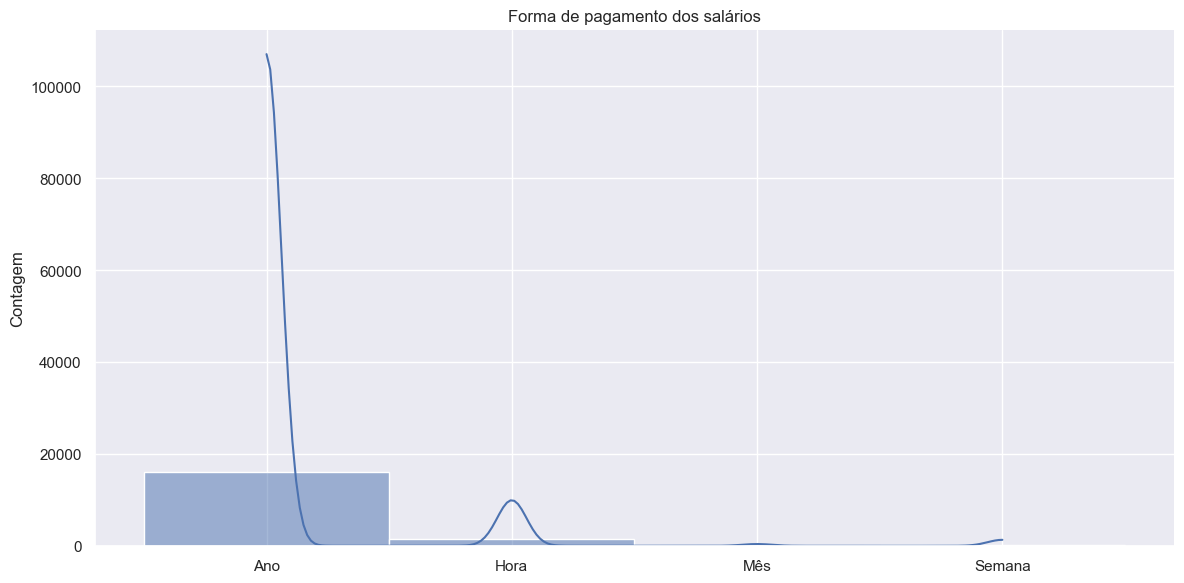

In [19]:
sns.displot(data=df, x="periodicidade", kde=True, height=6, aspect=2).set(title='Forma de pagamento dos salários', xlabel=None, ylabel='Contagem');

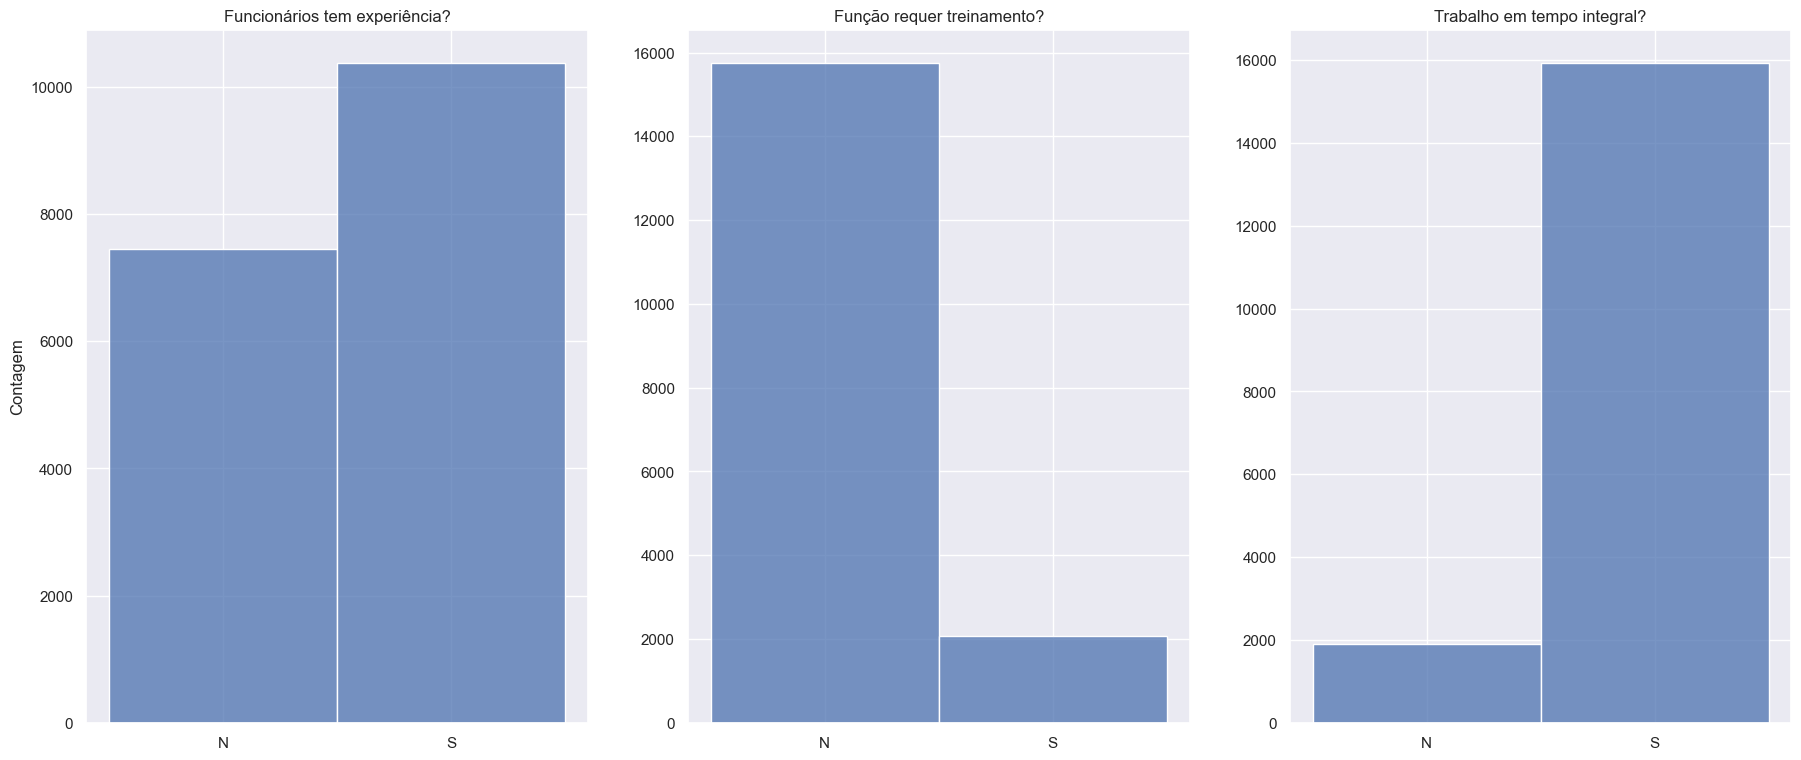

In [20]:
plt.subplot(1,3,1)
sns.histplot(data=df, x="tem_experiencia" ).set(title='Funcionários tem experiência?', xlabel=None, ylabel='Contagem');

plt.subplot(1,3,2)
sns.histplot(data=df, x="requer_treinamento", ).set(title='Função requer treinamento?', xlabel=None, ylabel=None);

plt.subplot(1,3,3)
sns.histplot(data=df, x="tempo_integral", ).set(title='Trabalho em tempo integral?', xlabel=None, ylabel=None);

Verificando a variância das features


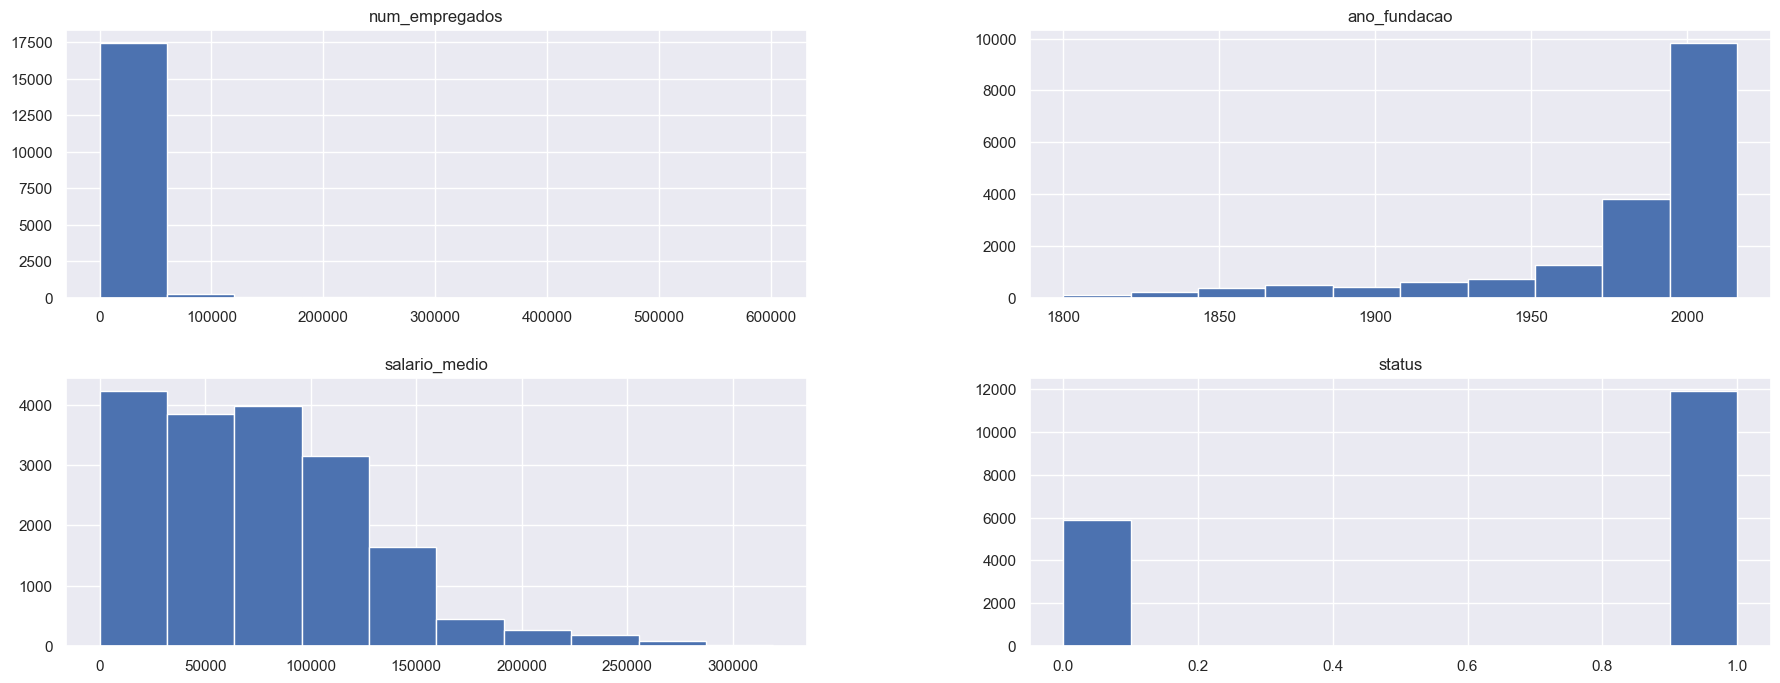

In [21]:
df.hist(figsize=(22,8));
print('Verificando a variância das features')

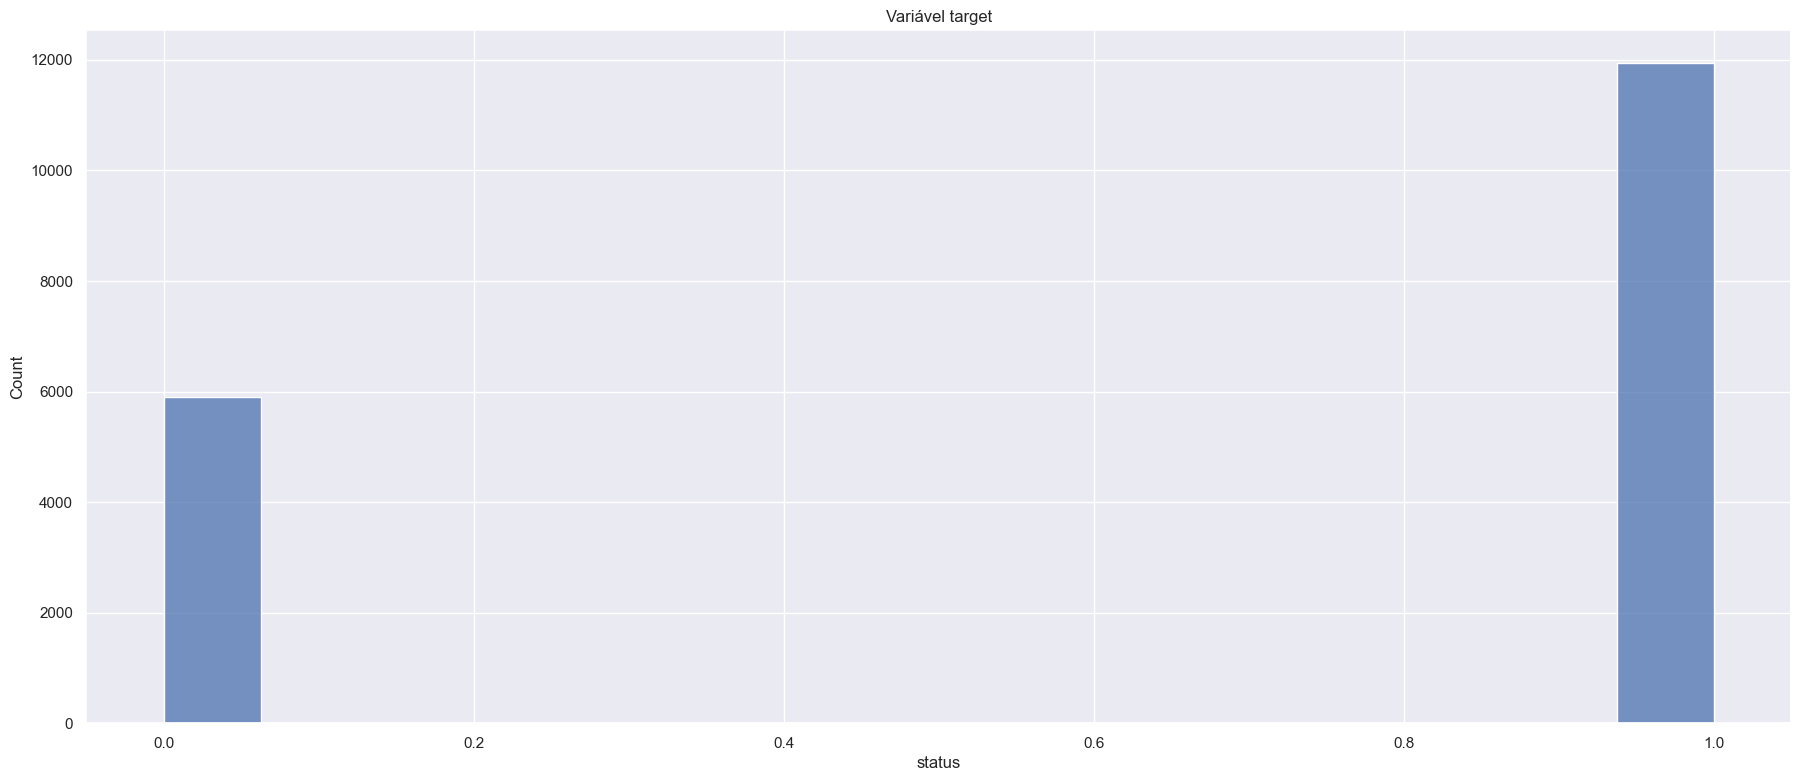

In [22]:
sns.histplot(df.status).set(title="Variável target");

## 2.2. Análise Bivariada

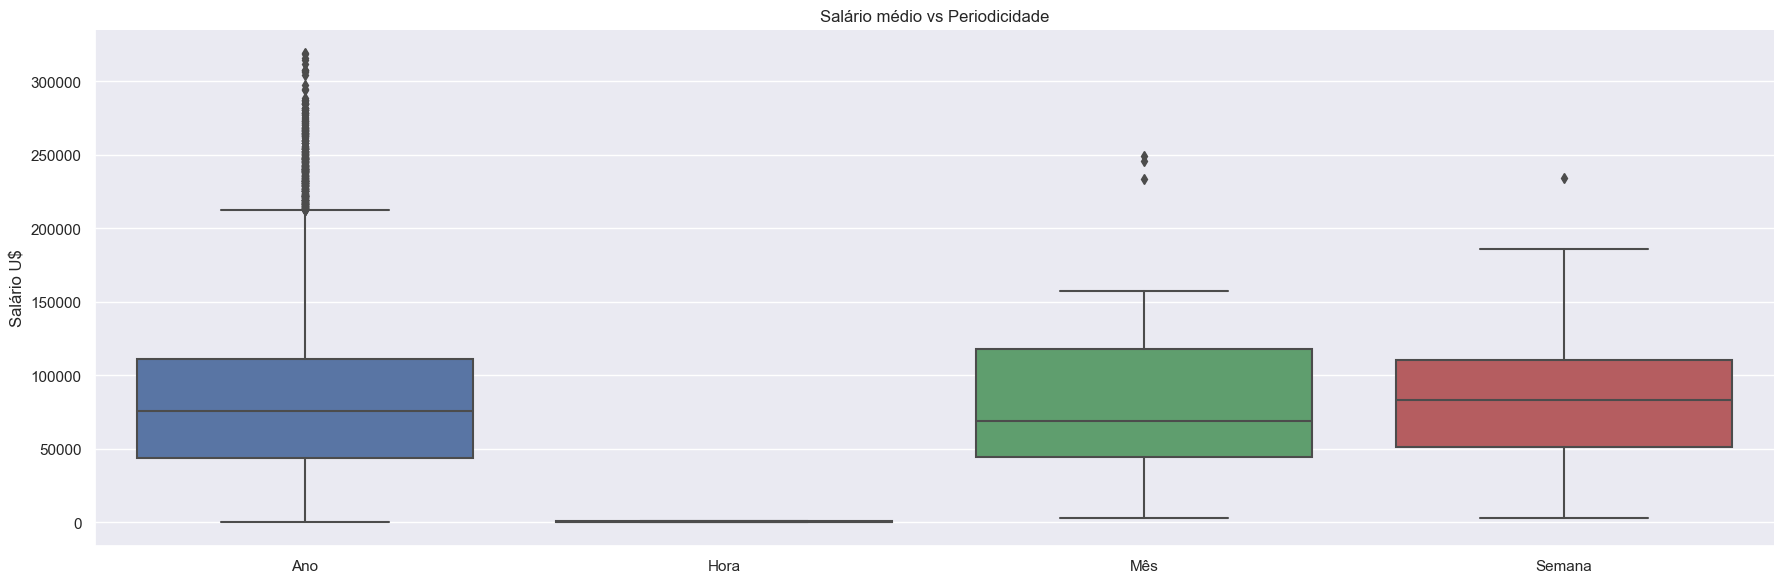

In [23]:
sns.catplot(data=df, x='periodicidade', y='salario_medio', kind='box', height=6, aspect=3,).set(title='Salário médio vs Periodicidade', ylabel='Salário U$', xlabel=None);

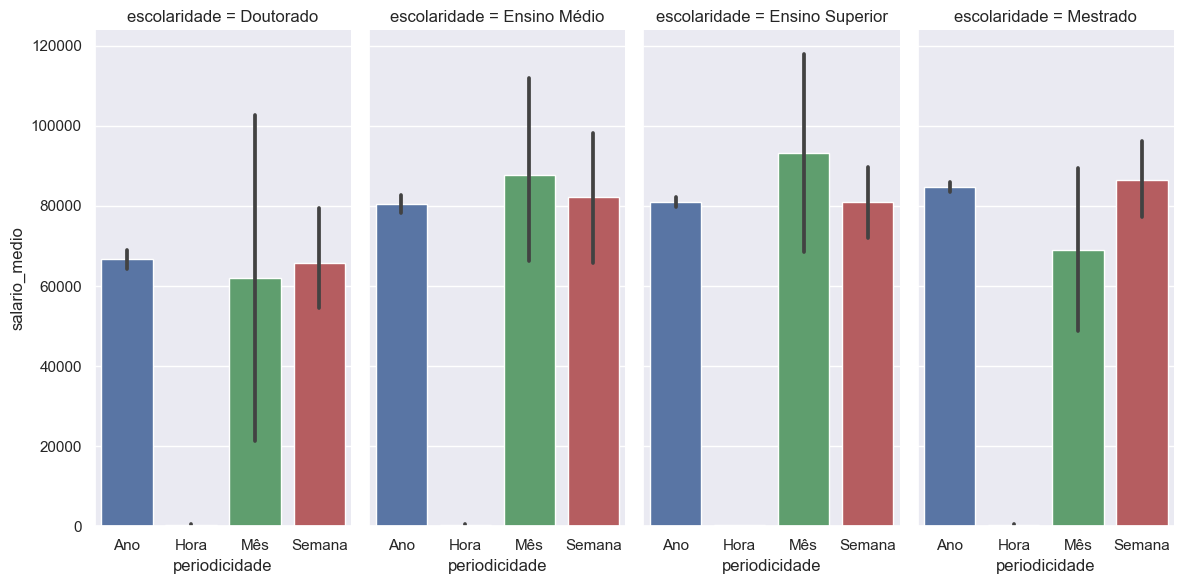

In [24]:
sns.catplot(data=df, x='periodicidade', y='salario_medio', col='escolaridade', kind='bar', height=6, aspect=.5);

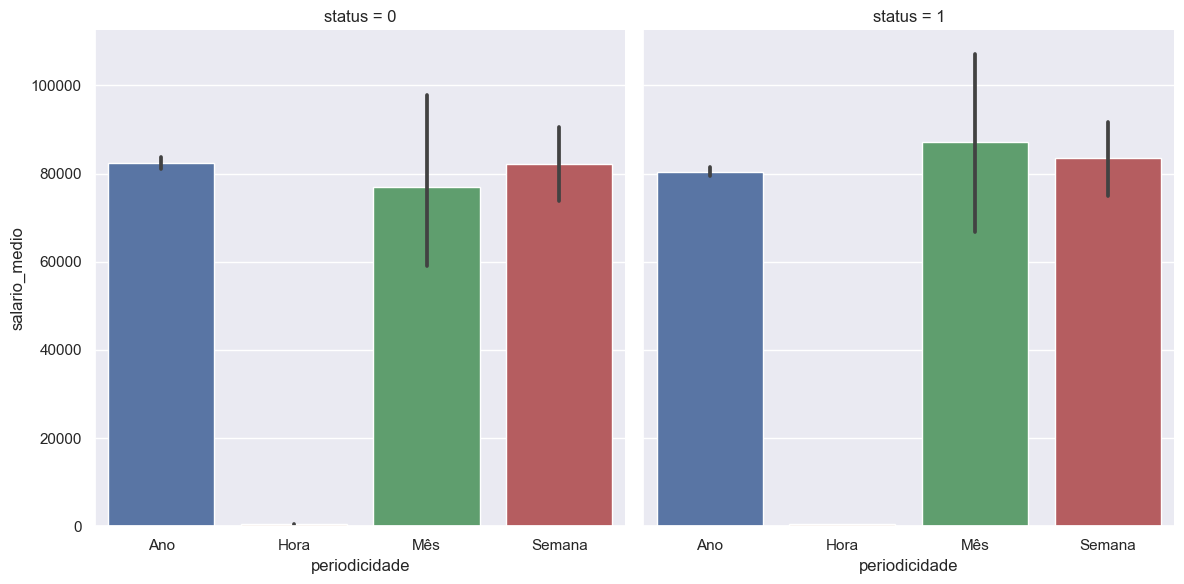

In [25]:
sns.catplot(data=df, x='periodicidade', y='salario_medio', col='status', kind='bar', height=6, aspect=1);

[Text(0.5, 1.0, 'Escolaridade x Aprovação do visto'),
 Text(0, 0.5, 'Contagem'),
 Text(0.5, 0, '')]

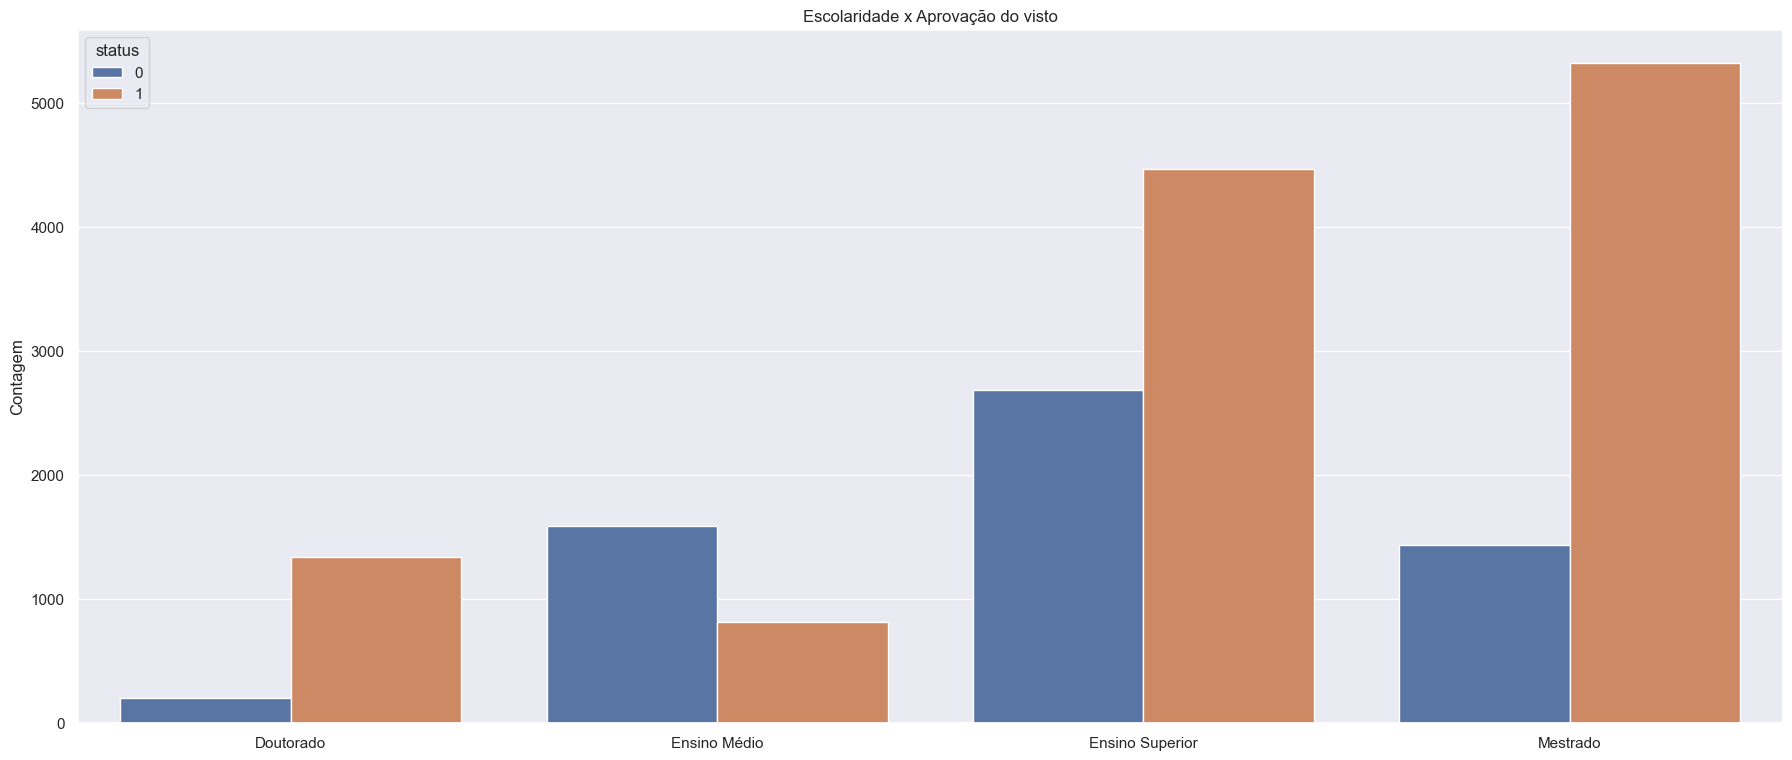

In [26]:
sns.countplot(data=df, x="escolaridade", hue="status").set(title='Escolaridade x Aprovação do visto', ylabel='Contagem', xlabel=None)

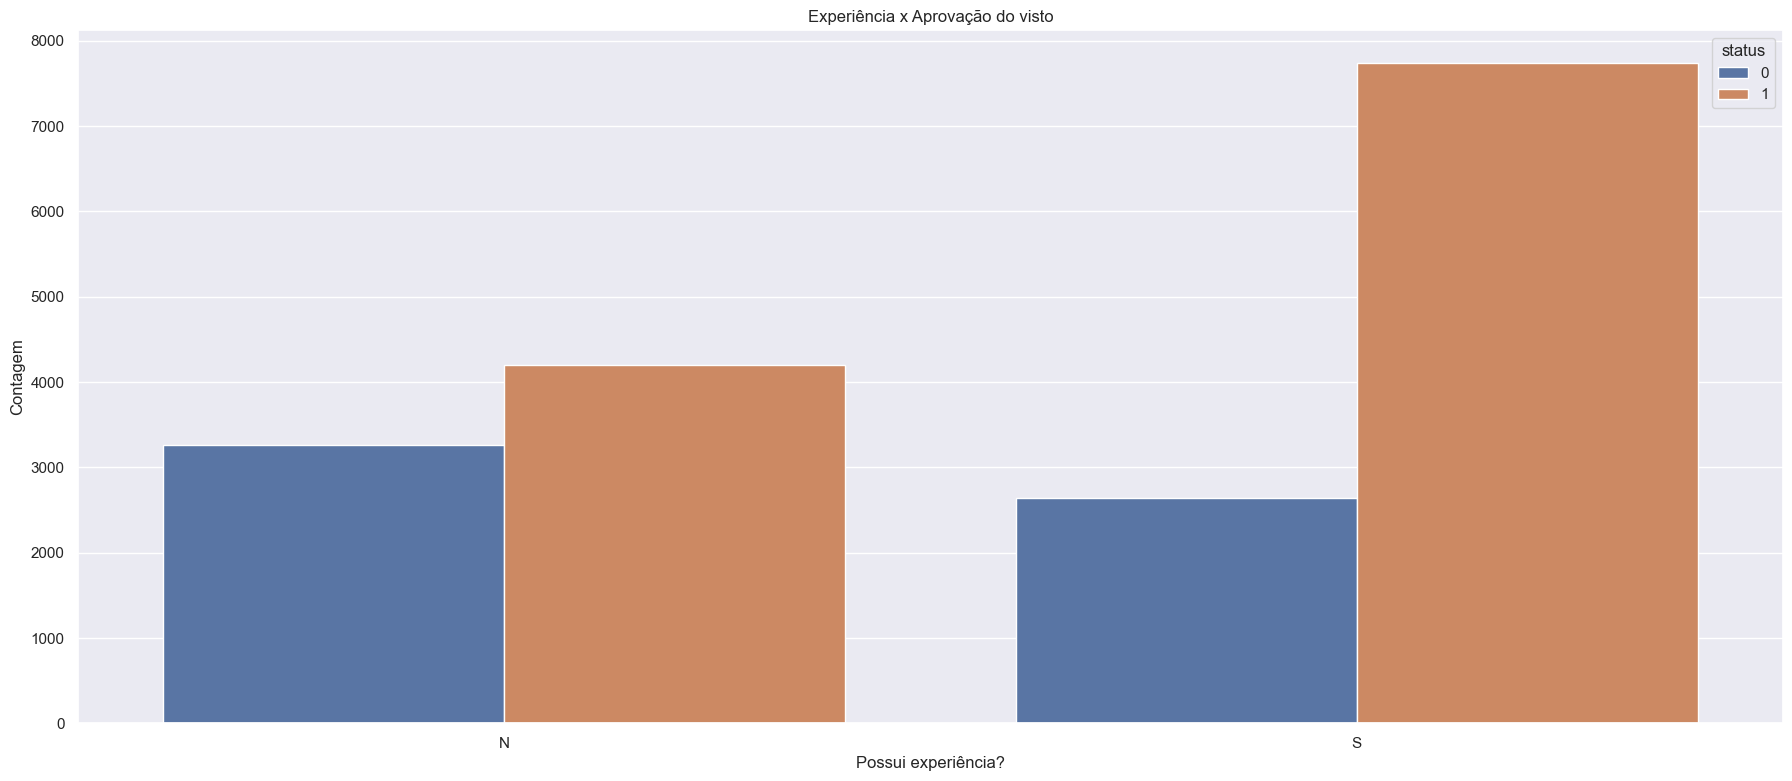

In [27]:
sns.countplot(data=df, x="tem_experiencia", hue="status").set(title='Experiência x Aprovação do visto', ylabel='Contagem', xlabel='Possui experiência?');

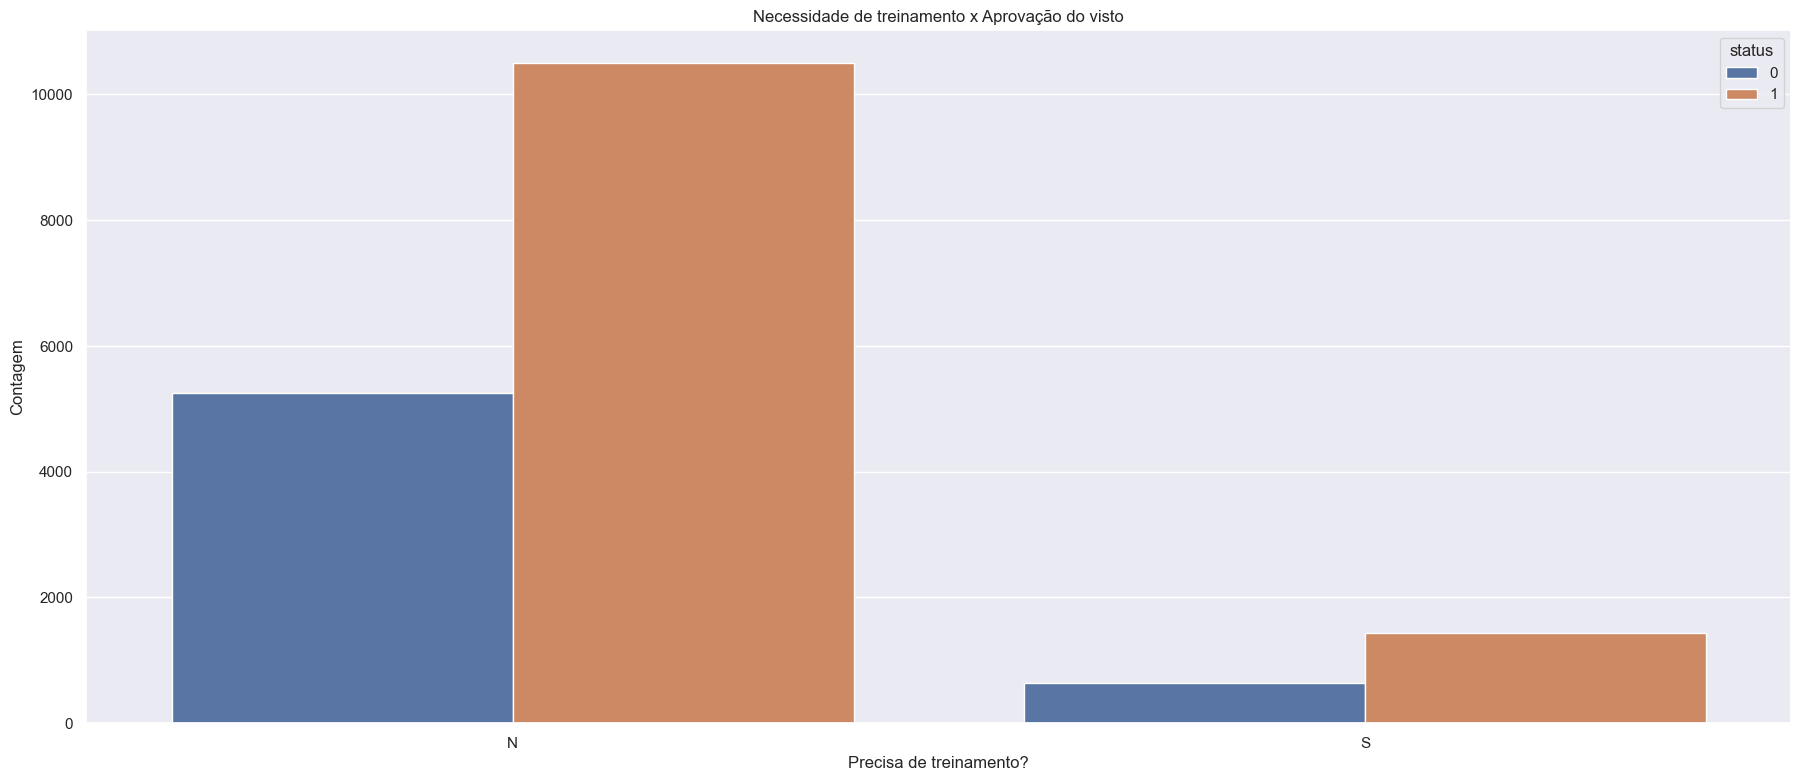

In [28]:
sns.countplot(data=df, x="requer_treinamento", hue="status").set(title='Necessidade de treinamento x Aprovação do visto', ylabel='Contagem', xlabel='Precisa de treinamento?');

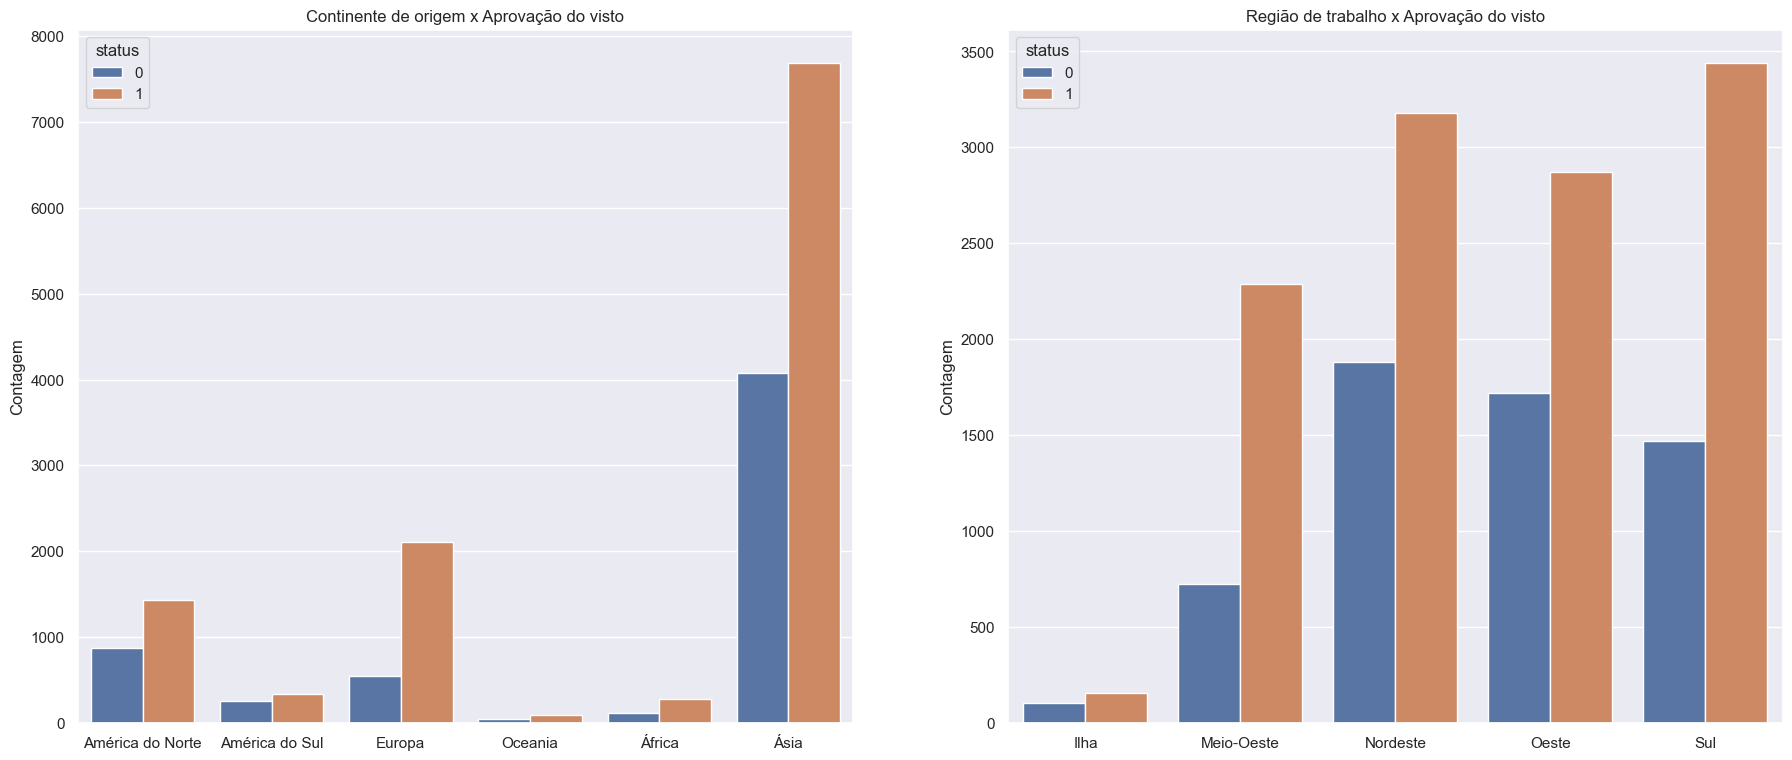

In [29]:
plt.subplot(1,2,1)
sns.countplot(data=df, x="continente", hue="status").set(title='Continente de origem x Aprovação do visto', ylabel='Contagem', xlabel=None);

plt.subplot(1,2,2)
sns.countplot(data=df, x="regiao", hue="status").set(title='Região de trabalho x Aprovação do visto', ylabel='Contagem', xlabel=None);


## 2.3. Análise Multivariada

In [30]:
corr = numerical_attributes.corr().round(1)
corr

,num_empregados,ano_fundacao,salario_medio,status
num_empregados,1.00,-0.00,-0.00,0.00
ano_fundacao,-0.00,1.00,0.00,0.00
salario_medio,-0.00,0.00,1.00,0.10
status,0.00,0.00,0.10,1.00


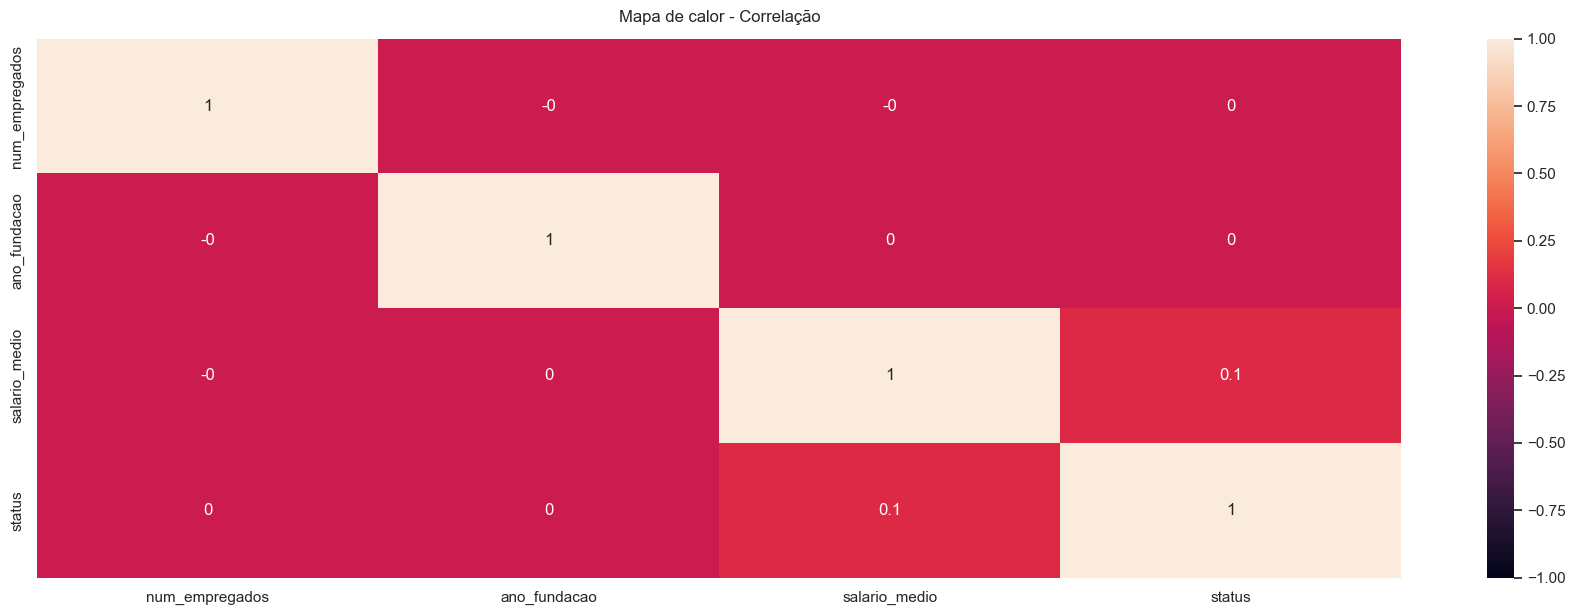

In [31]:
plt.figure(figsize=(22, 7))
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True)
heatmap.set_title("Mapa de calor - Correlação", fontdict={"fontsize": 12}, pad=12);

# 3 - Feature selection

## 3.1. Filtragem de linhas

In [32]:
# TODO

## 3.2. Filtragem de colunas

In [33]:
# TODO

# 4 - Data preparation

In [34]:
df2 = df.copy()

# dividindo em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    df2.drop(columns=["id", "status"], axis=1), df2["status"], test_size=0.2, random_state=42
)

# ======================== PRÉ PROCESSAMENTO ===============================


# =======
def pre_processa(data):
    df_pre = data.copy()

    # pipeline para pré-processamento das variáveis binárias
    for col in df_pre[['tem_experiencia', 'requer_treinamento', 'tempo_integral']].columns:
        df_pre[col] = df_pre[col].apply(lambda x: 0 if x=='N' else 1)

    # Criar feature de salário mensal
    df_pre['salario_medio_mes'] = df_pre.apply( lambda linha: 
                                        linha['salario_medio'] / 12 if (linha['periodicidade']=='Ano') else 
                                        linha['salario_medio'] if (linha['periodicidade']=='Mês') else 
                                        linha['salario_medio'] * 4         if (linha['periodicidade']=='Semana') else 
                                        linha['salario_medio'] * 8 * 30    if ((linha['periodicidade']=='Hora') & (linha['tempo_integral']==1)) else 
                                        linha['salario_medio'] * 4 * 30    if ((linha['periodicidade']=='Hora') & (linha['tempo_integral']==0)) 
                                        else 0, 
                                        axis=1)
    df_pre.drop(columns=['salario_medio', 'periodicidade'], inplace=True)

    # Corrigir empresas com qtd de funcionários negativos
    df_pre.num_empregados = df_pre.num_empregados.apply( lambda x: df_pre.num_empregados.median() if x < 1 else x)

    # Criar categorias para quantidade de funcionários (micro, pequena, média, grande):
    # 1-até 100; 2-até 1000; 3-até 5000; 4-maior que 5000;
    df_pre.num_empregados = df_pre.num_empregados.apply(lambda x: 1 if x <= 100 else 2 if x <= 1000 else 3 if x <= 5000 else 4)

    # Criar categorias para o ano de fundação (antiga, consolidada, nova):
    # 3-anterior a 1950; 2-anterior a 2000; 1-posterior a 2000;
    df_pre.ano_fundacao = df_pre.ano_fundacao.apply(lambda x: 3 if x <= 1950 else 2 if x <= 2000 else 1)

    # pipeline para pré-processamento das variáveis categóricas
    ord_enc = OrdinalEncoder()
    df_pre[['continente', 'escolaridade', 'regiao', ]] = ord_enc.fit_transform(df_pre[['continente', 'escolaridade', 'regiao', ]])

    # pipeline para pré-processamento das variáveis binárias
    # ohe_enc = OneHotEncoder()
    # df_pre[['tem_experiencia', 'requer_treinamento', 'tempo_integral']] = ohe_enc.fit_transform(df_pre[['tem_experiencia', 'requer_treinamento', 'tempo_integral']])

    # Salário categorizado
    df_pre.salario_medio_mes = df_pre.salario_medio_mes.apply(lambda x: 
                                                              7 if x <= 2000 else 
                                                              6 if x <= 4000 else 
                                                              5 if x <= 6000 else 
                                                              4 if x <= 8000 else 
                                                              3 if x <= 10000 else 
                                                              2 if x <= 20000 else 1)
    

    return df_pre

# Pré processa os dados
X_train = pre_processa(X_train)
X_test = pre_processa(X_test)
df3 = pre_processa( df2 )

# pipeline para pré-processamento das variáveis binárias
encode_transformer = Pipeline(steps=[('encoder', OneHotEncoder(drop='if_binary'))])

# pipeline para pré-processamento das variáveis categóricas
scale_transformer = Pipeline(steps=[("scaler", StandardScaler())])



# Compondo os pré-processadores
preprocessor = ColumnTransformer(
    transformers=[
        ("ohe", encode_transformer, list( df3.drop(columns=["id", "status", "continente", "escolaridade", "num_empregados", "ano_fundacao", "regiao", "salario_medio_mes", "status" ]))),
        ("scaler", scale_transformer, list( df3.drop(columns=["id", "status"]))),
    ]
)

In [35]:
df3.head(2)

,id,continente,escolaridade,tem_experiencia,requer_treinamento,num_empregados,ano_fundacao,regiao,tempo_integral,status,salario_medio_mes
0,EZYV10567,2.00,1.00,0,1,3,3,4.00,1,0,5
1,EZYV5505,5.00,3.00,1,0,4,1,1.00,1,1,5


# 5 - Modeling

## Pré processamento

In [36]:
# Carregando os dados de teste
df_test = test_raw.copy()

# Processando os dados de teste
df_test.columns = ['id', 'continente', 'escolaridade',
       'tem_experiencia', 'requer_treinamento',
       'num_empregados', 'ano_fundacao', 'regiao',
       'salario_medio', 'periodicidade',
       'tempo_integral', ]

df_test.id = df_test.id.astype('string')
df_test.continente = df_test.continente.astype('category')
df_test.escolaridade = df_test.escolaridade.astype('category')
df_test.tem_experiencia = df_test.tem_experiencia.astype('category')
df_test.requer_treinamento = df_test.requer_treinamento.astype('category')
df_test.num_empregados = df_test.num_empregados.astype('int32')
df_test.ano_fundacao = df_test.ano_fundacao.astype('int32')
df_test.regiao = df_test.regiao.astype('category')
df_test.salario_medio = df_test.salario_medio.astype('float32')
df_test.periodicidade = df_test.periodicidade.astype('category')
df_test.tempo_integral = df_test.tempo_integral.astype('category')

df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
num_empregados,7644.00,5528.31,21809.03,-26.00,1020.00,2094.50,3501.00,547172.00
ano_fundacao,7644.00,1979.21,42.99,1800.00,1976.00,1997.00,2005.00,2016.00
salario_medio,7644.00,74755.38,52865.02,3.00,34178.03,70716.77,108106.94,306206.66


In [37]:
df_test = pre_processa(df_test)
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
continente,7644.00,3.75,1.89,0.00,2.00,5.00,5.00,5.00
escolaridade,7644.00,2.07,0.92,0.00,2.00,2.00,3.00,3.00
num_empregados,7644.00,2.84,0.63,1.00,3.00,3.00,3.00,4.00
ano_fundacao,7644.00,1.78,0.70,1.00,1.00,2.00,2.00,3.00
regiao,7644.00,2.61,1.10,0.00,2.00,3.00,4.00,4.00
salario_medio_mes,7644.00,3.97,1.86,1.00,2.00,4.00,6.00,7.00


<Axes: xlabel='salario_medio_mes', ylabel='Count'>

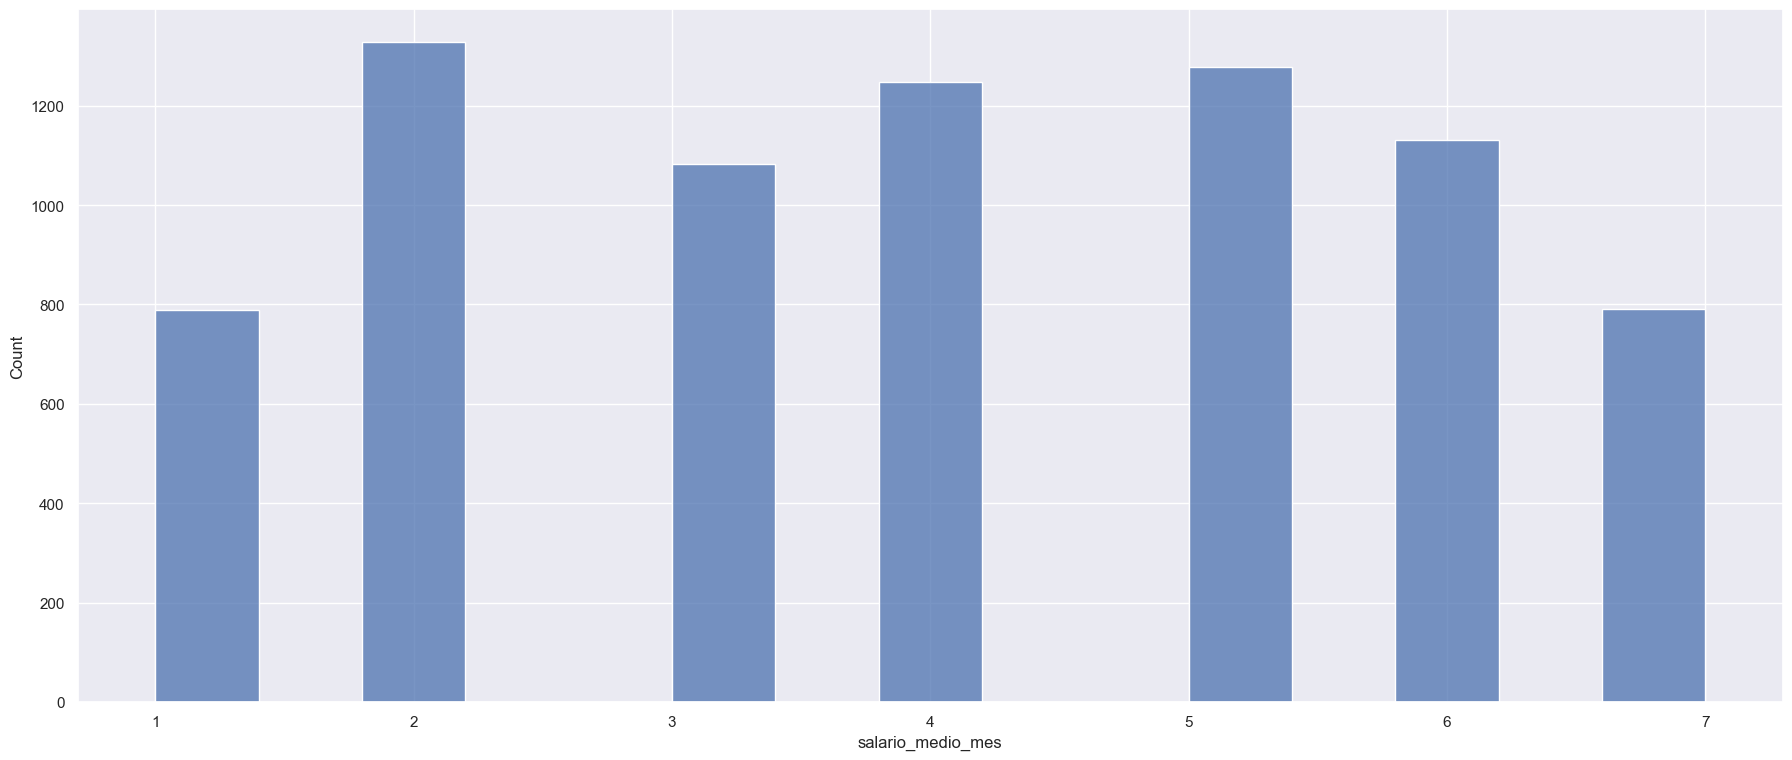

In [38]:
sns.histplot( data=df_test, x='salario_medio_mes' )

<Axes: xlabel='salario_medio', ylabel='Count'>

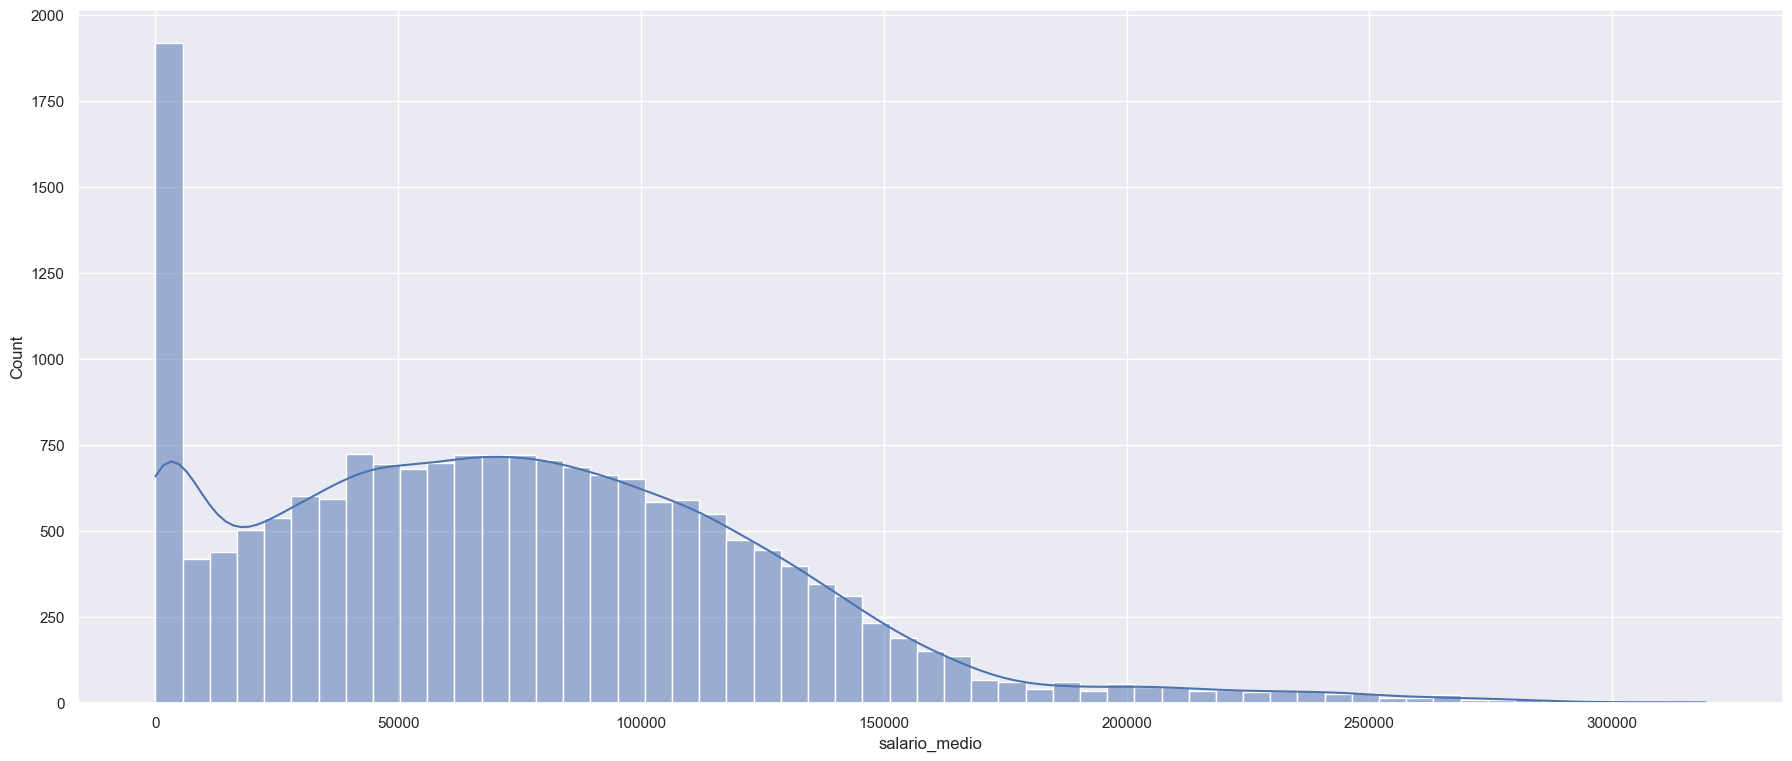

In [39]:
sns.histplot( data=df2, x='salario_medio', kde=True )

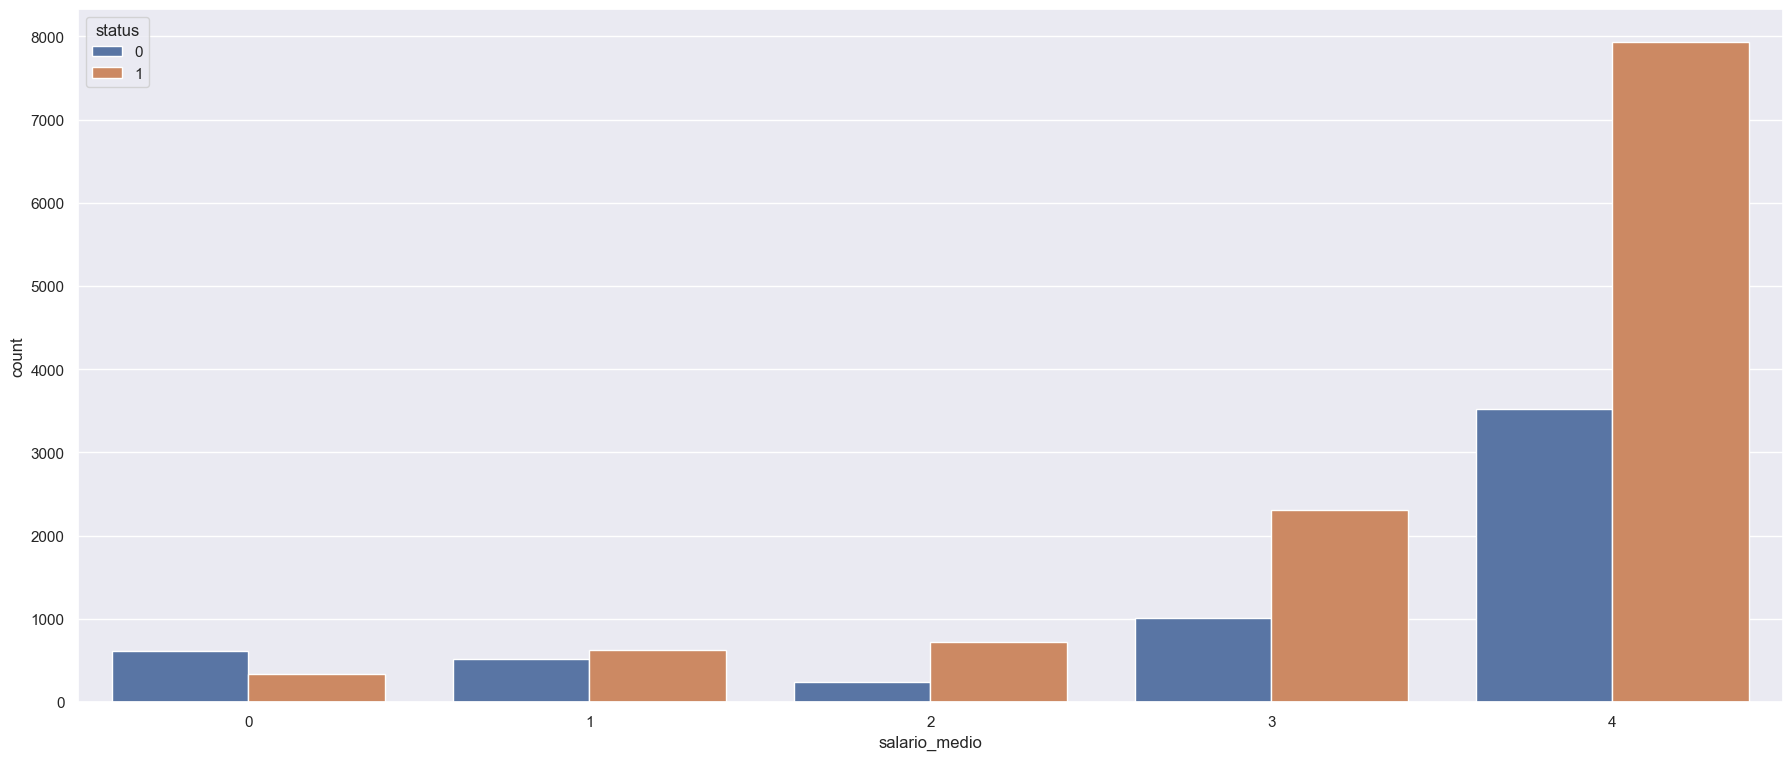

In [40]:
df_target = df2.copy()
df_target.salario_medio = df_target.salario_medio.apply(lambda x: 
                                                              0 if x <= 500 else 
                                                              1 if x <= 8000 else 
                                                              2 if x <= 20000 else 
                                                              3 if x <= 50000 else 
                                                              4 )

sns.countplot(data=df_target, x="salario_medio", hue="status");

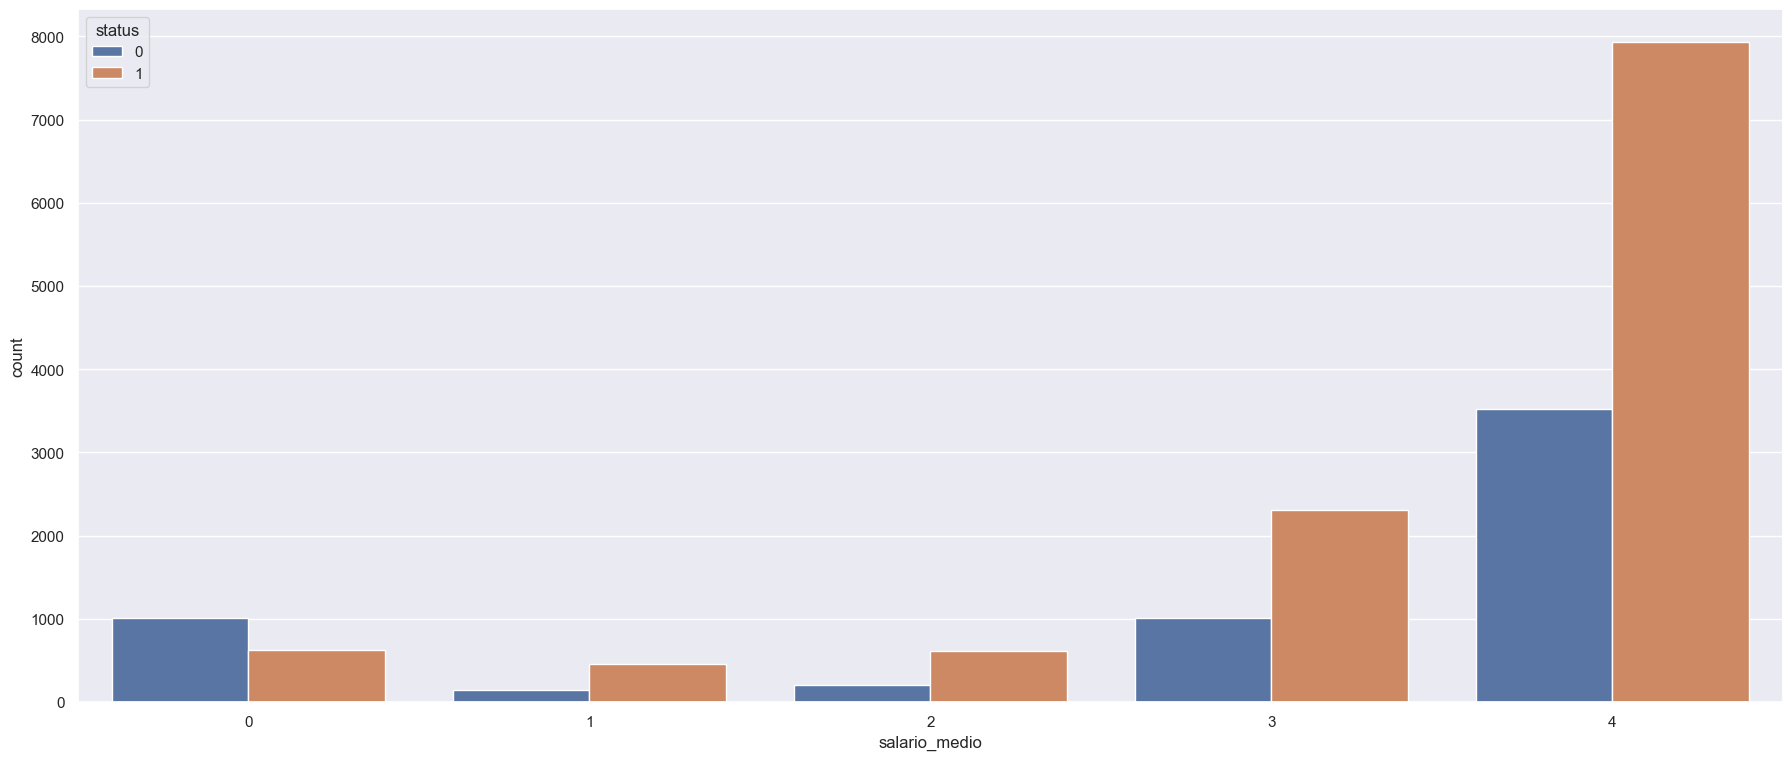

In [41]:
df_target = df2.copy()
df_target.salario_medio = df_target.salario_medio.apply(lambda x: 
                                                              0 if x <= 2000 else 
                                                              1 if x <= 10000 else 
                                                              2 if x <= 20000 else 
                                                              3 if x <= 50000 else 
                                                              4 )

sns.countplot(data=df_target, x="salario_medio", hue="status");

In [42]:
df2.head(2)

,id,continente,escolaridade,tem_experiencia,requer_treinamento,num_empregados,ano_fundacao,regiao,salario_medio,periodicidade,tempo_integral,status
0,EZYV10567,Europa,Ensino Médio,N,S,2087,1855,Sul,69711.24,Ano,S,0
1,EZYV5505,Ásia,Mestrado,S,N,5991,2003,Meio-Oeste,52931.38,Ano,S,1


In [43]:
# print(teste2)

## Load best parameters

In [44]:
with open('../models/lr.pickle', 'rb') as handle:
    best_params_lr = pickle.load(handle)

with open('../models/svm.pickle', 'rb') as handle:
    best_params_svm = pickle.load(handle)

with open('../models/xgb.pickle', 'rb') as handle:
    best_params_xgb = pickle.load(handle)

with open('../models/lgbm.pickle', 'rb') as handle:
    best_params_lgbm = pickle.load(handle)

## 5.1. Logistic Regression

In [45]:
# model_name = 'lr'

# # Usando os melhores parâmetros do Cross validation
# model_submission_lr = Pipeline(
#     steps=[
#         ("preprocessor", preprocessor),
#         (
#             "lr",
#             LogisticRegression(
#                 C               = best_params_lr[model_name + '__' + "C"],
#                 penalty         = best_params_lr[model_name + '__' + "penalty"],
#                 tol             = best_params_lr[model_name + '__' + "tol"],
#                 solver          = best_params_lr[model_name + '__' + "solver"],
#                 max_iter        = best_params_lr[model_name + '__' + "max_iter"],
#                 class_weight    = best_params_lr[model_name + '__' + "class_weight"],
#             ),
#         ),
#     ]
# )

# # treinando o modelo
# model_submission_lr.fit(X_train, y_train)

# # testando o modelo
# df_test['status_do_caso'] = model_submission_lr.predict(df_test.drop(columns=['id']))

# # Preparando a submissão
# submission_lr = df_test[['id', 'status_do_caso']].copy()
# submission_lr.columns = ['id_do_caso', 'status_do_caso']

# # Exportando a submissão
# submission_lr.to_csv('../submissions/submission_lr_processada.csv', index=False)

## 5.2. Suport Vector Machine

In [46]:
# model_name = 'svm'

# # Usando os melhores parâmetros do Cross validation
# model_submission_svm = Pipeline(
#     steps=[
#         ("preprocessor", preprocessor),
#         (
#             "svm",
#             SVC(
#                 kernel          = best_params_svm[model_name + '__' + "kernel"],
#                 C               = best_params_svm[model_name + '__' + "C"],
#                 gamma           = best_params_svm[model_name + '__' + "gamma"],
#                 degree          = best_params_svm[model_name + '__' + "degree"],
#                 coef0           = best_params_svm[model_name + '__' + "coef0"],
#                 class_weight    = best_params_svm[model_name + '__' + "class_weight"],
#             ),
#         ),
#     ]
# )

# # treinando o modelo
# model_submission_svm.fit(X_train, y_train)

# # testando o modelo
# df_test['status_do_caso'] = model_submission_svm.predict(df_test.drop(columns=['id']))

# # Preparando a submissão
# submission_svm = df_test[['id', 'status_do_caso']].copy()
# submission_svm.columns = ['id_do_caso', 'status_do_caso']

# # Exportando a submissão
# submission_svm.to_csv('../submissions/submission_svm_processada.csv', index=False)

## 5.3. XGBoost

In [47]:
df.status.value_counts()

1    11937
0     5899
Name: status, dtype: int64

In [48]:
model_name = 'xgboost'

scale_pos_weight = 0.70

# Usando os melhores parâmetros do Cross validation
model_submission_xgb = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "xbg",
            xgb.XGBClassifier(
                learning_rate       = best_params_xgb[model_name + '__' + "learning_rate"],
                n_estimators        = best_params_xgb[model_name + '__' + "n_estimators"],
                max_depth           = best_params_xgb[model_name + '__' + "max_depth"],
                min_child_weight    = best_params_xgb[model_name + '__' + "min_child_weight"],
                reg_alpha           = best_params_xgb[model_name + '__' + "reg_alpha"],
                reg_lambda          = best_params_xgb[model_name + '__' + "reg_lambda"],
                colsample_bytree    = best_params_xgb[model_name + '__' + "colsample_bytree"],
                objective           = best_params_xgb[model_name + '__' + "objective"],
                tree_method         = best_params_xgb[model_name + '__' + "tree_method"],
                eta                 = best_params_xgb[model_name + '__' + "eta"],
                random_state        = best_params_xgb[model_name + '__' + "random_state"],
                scale_pos_weight    = scale_pos_weight,
            ),
        ),
    ]
)

# treinando o modelo
model_submission_xgb.fit(X_train, y_train)

# testando o modelo
df_test['status_do_caso'] = model_submission_xgb.predict(df_test.drop(columns=['id']))

# Preparando a submissão
submission_xgb = df_test[['id', 'status_do_caso']].copy()
submission_xgb.columns = ['id_do_caso', 'status_do_caso']

# Exportando a submissão
submission_xgb.to_csv('../submissions/submission_xgb_processada.csv', index=False)

## 5.4. LGBM

In [49]:
model_name = 'lgbm'

# Usando os melhores parâmetros do Cross validation
model_submission_lgbm = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "xbg",
            lgb.LGBMClassifier(
                # class_weight        = best_params_lgbm[model_name + '__' + "class_weight"],
                objective           = best_params_lgbm[model_name + '__' + "objective"],
                boosting_type       = best_params_lgbm[model_name + '__' + "boosting_type"],
                n_estimators        = best_params_lgbm[model_name + '__' + "n_estimators"],
                max_depth           = best_params_lgbm[model_name + '__' + "max_depth"],
                random_state        = best_params_lgbm[model_name + '__' + "random_state"],
                learning_rate       = best_params_lgbm[model_name + '__' + "learning_rate"],
                min_child_samples   = best_params_lgbm[model_name + '__' + "min_child_samples"],
                subsample           = best_params_lgbm[model_name + '__' + "subsample"],
                colsample_bytree    = best_params_lgbm[model_name + '__' + "colsample_bytree"],
                reg_alpha           = best_params_lgbm[model_name + '__' + "reg_alpha"],
                reg_lambda          = best_params_lgbm[model_name + '__' + "reg_lambda"],
                scale_pos_weight    = 0.71,
            ),
        ),
    ]
)

# treinando o modelo
model_submission_lgbm.fit(X_train, y_train)

# testando o modelo
df_test['status_do_caso'] = model_submission_lgbm.predict(df_test.drop(columns=['id']))

# Preparando a submissão
submission_lgbm = df_test[['id', 'status_do_caso']].copy()
submission_lgbm.columns = ['id_do_caso', 'status_do_caso']

# Exportando a submissão
submission_lgbm.to_csv('../submissions/submission_lgbm_processada.csv', index=False)

In [50]:
print('XGBoost:')
for key, value in best_params_xgb.items():
    print(f'{key}: {value}')

print('\nLightGBM:')
for key, value in best_params_lgbm.items():
    print(f'{key}: {value}')

XGBoost:
xgboost__colsample_bytree: 0.9
xgboost__eta: 0.7
xgboost__learning_rate: 0.01
xgboost__max_depth: 7
xgboost__min_child_weight: 1
xgboost__n_estimators: 500
xgboost__objective: binary:logistic
xgboost__random_state: 42
xgboost__reg_alpha: 0.001
xgboost__reg_lambda: 0.1
xgboost__tree_method: hist

LightGBM:
lgbm__boosting_type: dart
lgbm__class_weight: balanced
lgbm__colsample_bytree: 0.7
lgbm__learning_rate: 0.01
lgbm__max_depth: 10
lgbm__min_child_samples: 5
lgbm__n_estimators: 500
lgbm__objective: binary
lgbm__random_state: 42
lgbm__reg_alpha: 0.01
lgbm__reg_lambda: 0.01
lgbm__subsample: 0.9


## Próximos passos
- **x** aplicar scaler
- **x** corrigir empresas com funcionários negativos
- **x** aplicar ordinal encoder no ano de fundação
- **x** criar feature salário mensal
- verificar relevância de experiência, treinamento, integral, escolaridade, regiao, continente.
- **x** tratar outliers
- novos algoritmos
- balancemanto de classe target
- ensemble
- **x** Não usar scaler para variáveis binárias
- **x** Alterar ordem da escolaridade
- **x** Excluir Treinamento, Região e Continente

In [51]:
# df_pre.salario_medio_mes = df_pre.salario_medio_mes.apply(lambda x: 
    #                                                           0 if x <= 500 else 
    #                                                           1 if x <= 8000 else 
    #                                                           2 if x <= 20000 else 
    #                                                           3 if x <= 50000 else 
    #                                                           4 )



    # # Salário sem outliers
    # data = sorted(df_pre.salario_medio_mes)
    # q1 = np.percentile(data, 25)
    # q3 = np.percentile(data, 75)
    # IQR = q3-q1
    # lwr_bound = q1-(1.5*IQR)
    # upr_bound = q3+(1.5*IQR)
    # df_pre.salario_medio_mes = df_pre.salario_medio_mes.apply(lambda x: df_pre.salario_medio_mes.median() if (x < lwr_bound) | (x > upr_bound) else x)

    # Retirando variáveis sem importância
    # df_pre.drop(columns=['requer_treinamento'], inplace=True)

# # Categorizar o nível de estudo
    # df_pre.escolaridade = df_pre.escolaridade.apply(lambda x: 
    #                                                 0 if x=="Ensino Médio" else
    #                                                 1 if x=="Ensino Superior" else
    #                                                 2 if x=="Doutorado" else
    #                                                 3)

    # # Reagrupando continente de origem
    # df_pre.continente = df_pre.continente.apply(lambda x:
    #                                             'Oce-Africa' if x == 'Oceania' else
    #                                             'Oce-Africa' if x == 'África' else
    #                                             'Oce-Africa' if x == 'Ásia' else
    #                                             x)


# scaler = StandardScaler()
    # df_pre[['continente', 'escolaridade', 'tem_experiencia',
    #    'requer_treinamento', 'num_empregados', 'ano_fundacao', 'regiao',
    #    'tempo_integral', 'salario_medio_mes', ]] = scaler.fit_transform(df_pre[['continente', 'escolaridade', 'tem_experiencia',
    #    'requer_treinamento', 'num_empregados', 'ano_fundacao', 'regiao',
    #    'tempo_integral', 'salario_medio_mes', ]])